In [1]:
# Ignoring warning for better presentation
options(warn=-1)

In [3]:
library(gbm)
library(caret)
library(Metrics)

In [4]:
#This notebook covers a R-based approach to Gradient Boosting Machine. We'll start with implementing a simple GBM model and then evalaute the model using AUC. Then we will tune our model's hyper-parameters for better performance. Another important feature of GBM is early stopping. We shall look into that as well.

In [5]:
# reading data file ~ credit.csv 
# taken from https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

# credit.csv is composed of qualitative and quantitative variables.
# For this exercise we will focus on all of the features

creditsub <- read.csv(file = '/home/dell/R_programming/case studies/trees/machinelearning-R/credit.csv', 
                      header = T)

# Let's take a look at the dataframe
head(creditsub)

checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no


In [6]:
# Let's split the data into train and test

# Setting seed for reproducible train and test partitions
set.seed(123)

smp_size <- floor(0.75 * nrow(creditsub))

train_ind <- sample(seq_len(nrow(creditsub)), size = smp_size)

credit_train <- creditsub[train_ind, ]

credit_test <- creditsub[-train_ind, ]

In [7]:
# Convert "yes" to 1, "no" to 0
credit_train$default <- ifelse(credit_train$default == "yes", 1, 0)

# Let's tart with a large 10000-tree GBM model, we will early stop it later
set.seed(123)
credit_model <- gbm(formula = default ~ ., 
                    distribution = 'bernoulli', 
                    data = credit_train,
                    n.trees = 10000)
                    
# Print the model object                    
print(credit_model)

gbm(formula = default ~ ., distribution = "bernoulli", data = credit_train, 
    n.trees = 10000)
A gradient boosted model with bernoulli loss function.
10000 iterations were performed.
There were 16 predictors of which 16 had non-zero influence.


In [8]:
#It seems that all the predictors are contributing to the final outupt, which means there weren't any noise varaibles.

,var,rel.inf
checking_balance,checking_balance,31.92846139
amount,amount,12.32593478
credit_history,credit_history,11.51111974
months_loan_duration,months_loan_duration,11.37219086
savings_balance,savings_balance,6.93661305
age,age,5.61484261
employment_duration,employment_duration,5.16360523
other_credit,other_credit,4.29210324
percent_of_income,percent_of_income,3.61073424
purpose,purpose,3.15533865


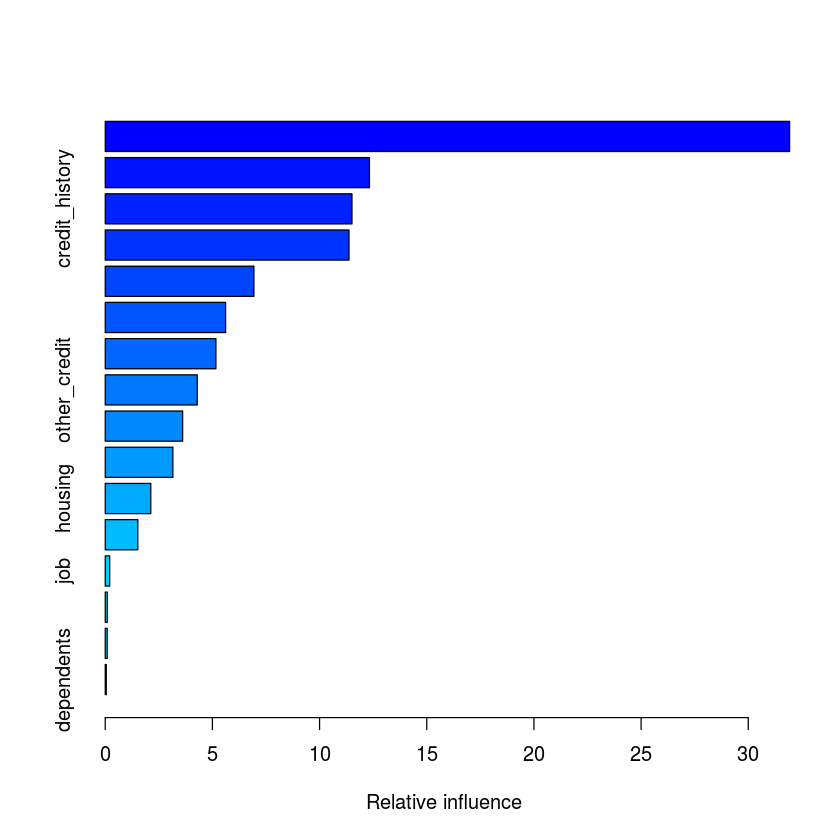

In [9]:
# Let's look at a more appealing description of the model
summary(credit_model)

In [10]:
#Checking balance seems to be the major predictor/influencer.

#Let's test our model on test set

In [11]:
credit_test$default <- ifelse(credit_test$default == "yes", 1, 0)

# Generating predictions on the test set
preds1 <- predict(object = credit_model, 
                  newdata = credit_test,
                  n.trees = 10000)

# Generating predictions on the test set. But this time let's scale the response.
# Scaling gives us a repsonse between 0 and 1
preds2 <- predict(object = credit_model, 
                  newdata = credit_test,
                  n.trees = 10000,
                  type = "response")

In [12]:
data.frame(head(preds1), head(preds2), head(credit_test$default))

head.preds1.,head.preds2.,head.credit_test.default.
-2.60228864,0.06899127,0
0.03700055,0.50924908,0
-0.49352135,0.37906438,1
-0.01856056,0.49535999,1
-0.45431649,0.38833497,1
-1.20899929,0.22987816,0


In [13]:
# Compare the range of the two sets of predictions
range(preds1)


[1] -3.363627  2.096204

In [14]:
range(preds2)

[1] 0.03345175 0.89053367

In [15]:
# Let's check out the AUC of the test set
auc(actual = credit_test$default, predicted = preds2)

[1] 0.8093714

In [16]:
#Note: AUC is same for preds1 and preds2 since it is based on ranks not scale. However, something like RMSE will be affected by rescaling. Here the AUC came out to be high which is a good sign about the model's accuracy.

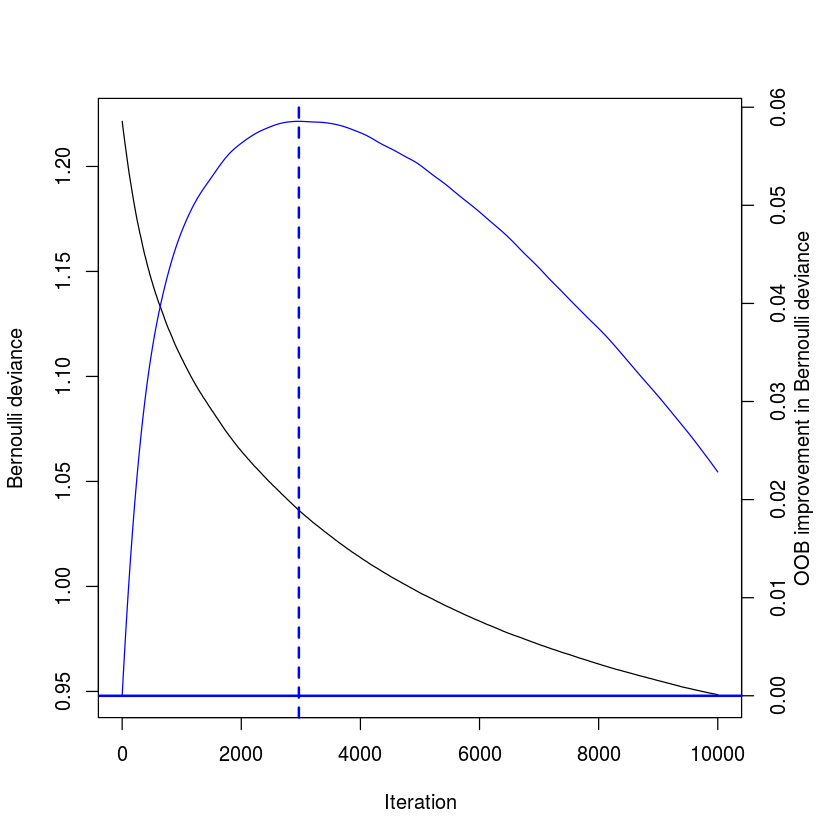

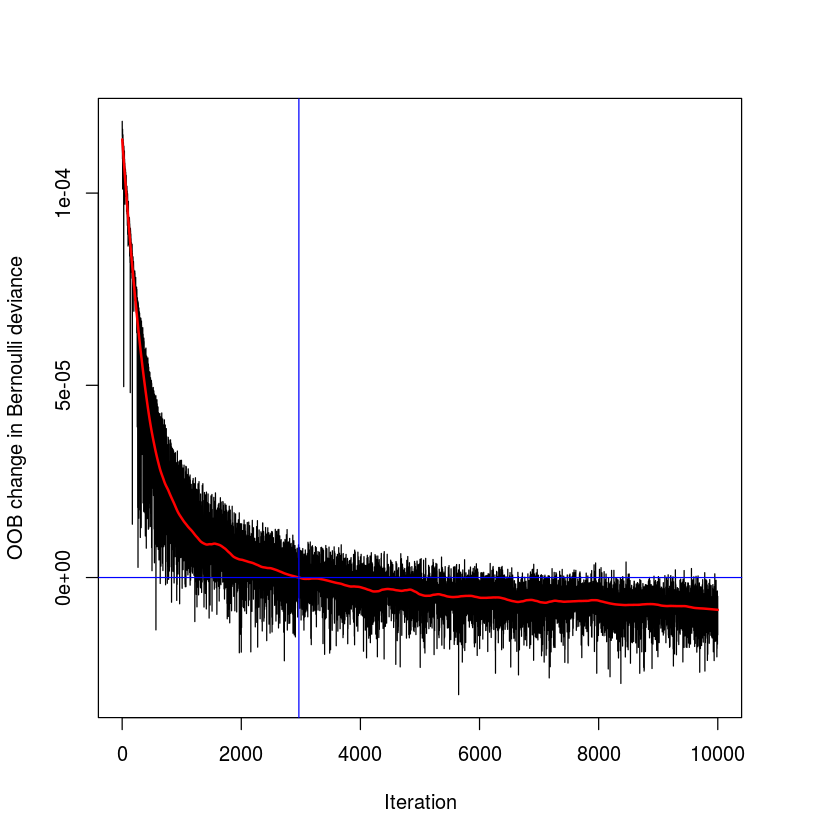

In [17]:
# Let's further optimize the model by tuning the hyperparameteres.
# Here we will be focusing on early stopping in order to optimize
# the number of trees in our model. 

# Since we already have a model trained,let's just tune that
ntree_opt_oob <- gbm.perf(object = credit_model, 
                          method = 'OOB', 
                          oobag.curve = TRUE)

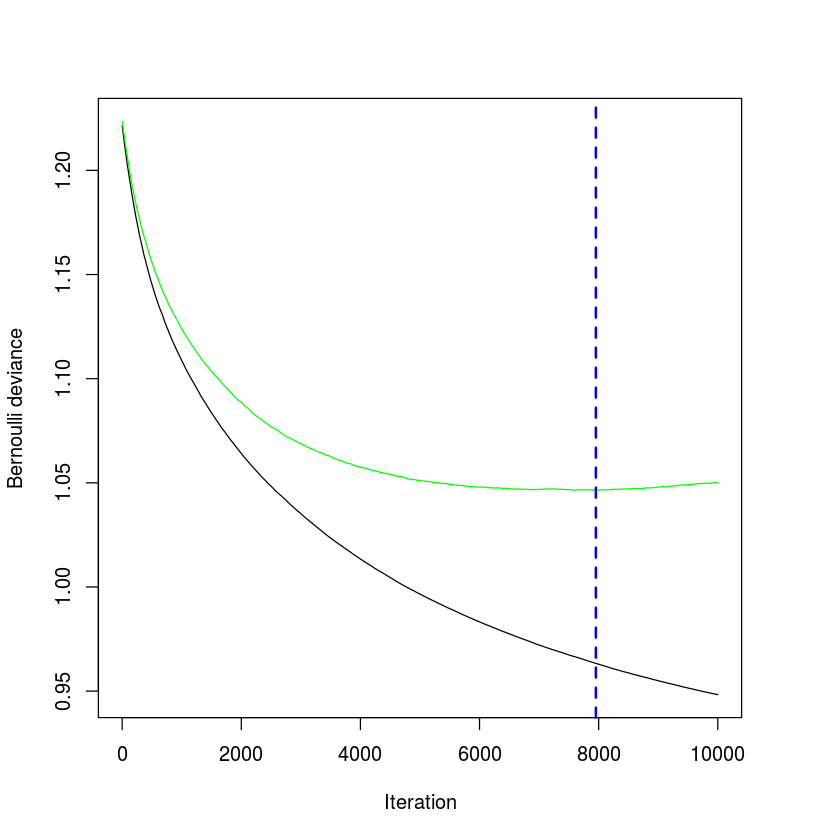

In [18]:
# For optimizing the ntrees using Cross-validation method we need to recreate our model
# with cv.folds.
credit_model_cv <- gbm(formula = default ~ ., 
                       distribution = "bernoulli", 
                       data = credit_train,
                       n.trees = 10000,
                       cv.folds = 2 # added for optimization
                      )

# Optimal ntree estimate based on CV
ntree_opt_cv <- gbm.perf(object = credit_model_cv,
                        method = 'cv')

In [19]:
# Compare the estimates                         
print(paste0("Optimal n.trees (OOB Estimate): ", ntree_opt_oob))                         
print(paste0("Optimal n.trees (CV Estimate): ", ntree_opt_cv))

[1] "Optimal n.trees (OOB Estimate): 2967"
[1] "Optimal n.trees (CV Estimate): 7953"


In [20]:
#The number of trees vary significantly. Let's test both of the ntree opt parameters to find out the suitable number of trees for this model.

In [21]:
# Predictions on the test set using ntree_opt_oob number of trees
preds1 <- predict(object = credit_model, 
                  newdata = credit_test,
                  n.trees = ntree_opt_oob)
                  
# Predictions on the test set using ntree_opt_cv number of trees
preds2 <- predict(object = credit_model_cv, 
                  newdata = credit_test,
                  n.trees = ntree_opt_cv)   

# Let's generate the test set AUCs using the two sets of preditions & compare
auc1 <- auc(actual = credit_test$default, predicted = preds1)  #OOB
auc2 <- auc(actual = credit_test$default, predicted = preds2)  #CV 

# Comparing AUC 
print(paste0("Test set AUC (OOB): ", auc1))                         
print(paste0("Test set AUC (CV): ", auc2))

[1] "Test set AUC (OOB): 0.791390476190476"
[1] "Test set AUC (CV): 0.806628571428571"


In [22]:
#The ntree_opt_cv came out to be a better hyperparameter for this model, with an AUC of 0.8.

#That's it for now. We can use other metrics as well to evaluate our model.